In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import scipy
import shutil
import numpy as np
from PIL import Image
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision.transforms as T
from tensorflow import keras, cast
from tensorflow.data import AUTOTUNE
from os import listdir, path , makedirs
from torchvision.datasets import ImageFolder
from tensorflow.keras.optimizers import Adam
# from tensorflow.data import AUTOTUNE as autotune
from tensorflow.keras import Model, backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img , ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Input , GlobalAveragePooling2D



In [ ]:

# Training parameters
batch_size = 45
img_height = 224
img_width = 224
epochs = 200
epsilon = 0.1

parent_dir = '/content/drive/My Drive/garbage dataset/parent_dir'  # Change this to your new directory
dataset_dir = '/content/drive/My Drive/garbage dataset/dataset'
train_dir = '/content/drive/My Drive/garbage dataset/train'
val_dir = '/content/drive/My Drive/garbage dataset/validation'
test_dir = '/content/drive/My Drive/garbage dataset/test'
train_adver_dir = '/content/drive/My Drive/garbage dataset/train_adversarial'
val_adver_dir = '/content/drive/My Drive/garbage dataset/val_adversarial'
test_adver_dir = '/content/drive/My Drive/garbage dataset/test_adversarial'
adversarial_and_normal_dir = '/content/drive/My Drive/garbage dataset/adversarial_and_normal_examples'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for class_name in os.listdir(dataset_dir):
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

In [ ]:
def copy_split_data(images, labels, train_dir, val_dir, test_dir, val_size=0.2, test_size=0.2):
    # First split the dataset into training and temp (validation + test) sets
    X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=(val_size + test_size), random_state=42)

    # Now split the temp set into validation and test sets
    val_test_split = test_size / (val_size + test_size)  # Adjust test size proportionally
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_test_split, random_state=42)

    # Create directories for train, validation, and test
    for class_name in set(labels):
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Copy training files
    for img_path, label in zip(X_train, y_train):
        shutil.copy(img_path, os.path.join(train_dir, label, os.path.basename(img_path)))

    # Copy validation files
    for img_path, label in zip(X_val, y_val):
        shutil.copy(img_path, os.path.join(val_dir, label, os.path.basename(img_path)))

    # Copy test files
    for img_path, label in zip(X_test, y_test):
        shutil.copy(img_path, os.path.join(test_dir, label, os.path.basename(img_path)))

# Example usage
images = [...]  # List of image file paths
labels = [...]  # Corresponding labels for the images


In [ ]:
# Function to load images and labels
def load_dataset(source_dir):
    images = []
    labels = []

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)

        if os.path.isdir(class_path):  # Check if it is a directory
            for file_name in os.listdir(class_path):
                #if file_name.endswith(('.jpg', '.jpeg', '.png')):  # Add more formats if needed
                img_path = os.path.join(class_path, file_name)
                images.append(img_path)  # Save the file path
                labels.append(class_name)  # Use the class name as the label

    return images, labels

In [ ]:
# Load dataset
images, labels = load_dataset(dataset_dir)
print(len(images))
# Copy the split data
#copy_split_data(images, labels, train_dir, val_dir)
#copy_split_data(images, labels, train_dir, val_dir, test_dir, val_size=0.2, test_size=0.2)


5326


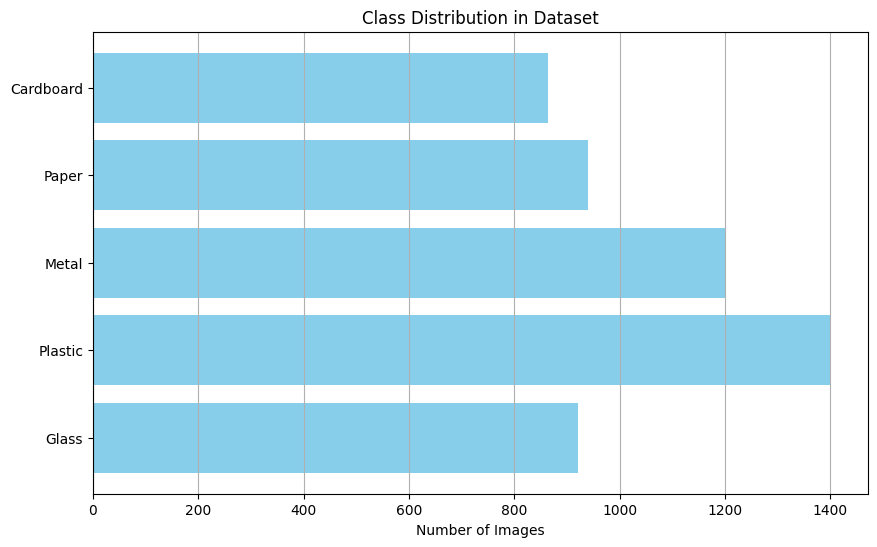

In [ ]:

def show_class_distribution(data_dir):
    class_counts = {}

    # Iterate through each class directory
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)

        # Check if it is a directory
        if os.path.isdir(class_path):
            # Count the number of image files in the class directory
            num_files = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))])
            class_counts[class_name] = num_files

    # Sort the class counts for better visualization
    class_names = list(class_counts.keys())
    counts = list(class_counts.values())

    # Plotting the class distribution
    plt.figure(figsize=(10, 6))
    plt.barh(class_names, counts, color='skyblue')
    plt.xlabel('Number of Images')
    plt.title('Class Distribution in Dataset')
    plt.grid(axis='x')
    plt.show()

show_class_distribution(dataset_dir)


In [ ]:
# Data processing
def process(image, label):
    image = cast(image / 255.0, 'float32')
    return image, label

In [ ]:

# Plotting training & validation accuracy and loss
def plot_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:

# train normal model

best_model_path = '/content/drive/My Drive/garbage dataset'
dataset_name = 'garbage'


# Learning rates
learn_rate_fc = 1e-4

# Callback to stop model training when model converges
model_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Check if training directory exists
if not path.exists(train_dir):
    raise ValueError(f"Training directory does not exist: {train_dir}")
if not path.exists(val_dir):
    raise ValueError(f"Validation directory does not exist: {val_dir}")

# ------------------------ Build and Train the Model ------------------------ #
# Build DenseNet121
base_model = DenseNet121(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Create classification layers
global_average_pooling = GlobalAveragePooling2D()
classifier = Dense(units=5, activation='softmax')

# Connect layers
inputs = Input(shape=(img_height, img_width, 3))
model = base_model(inputs)
model = global_average_pooling(model)
outputs = classifier(model)

# Build DenseNet121 model
dense_net_121 = Model(inputs, outputs, name='DenseNet121')


# ------------------------ Build data set------------------------ #

# Create training dataset
train_data = image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    label_mode='categorical'
)

# Normalize training dataset pixel values
train_ds = train_data.map(process)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create validation dataset
val_data = image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    label_mode='categorical'
)

# Normalize validation dataset pixel values
val_ds = val_data.map(process)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Compile model
dense_net_121.compile(
    optimizer=Adam(learn_rate_fc),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Train the model
print('\n|------------------------------| Training Fully Connected Layers |--------------------------------|\n')
model_checkpoint_fc = ModelCheckpoint(
    best_model_path + '/normal-densenet121-' + dataset_name + '-{epoch:02d}-{val_accuracy:.4f}.keras',
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)


# Example of using SGD with momentum

# Fit the model and save history
normal_densenet121 = dense_net_121.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[model_checkpoint_fc, model_callback]
)

print('\n|--------------------------| Training Complete |---------------------------|\n')

# Call the plot function
plot_history(normal_densenet121)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 3195 files belonging to 5 classes.
Found 1065 files belonging to 5 classes.

|------------------------------| Training Fully Connected Layers |--------------------------------|

Epoch 1/200
 82/100 ━━━━━━━━━━━━━━━━━━━━ 8s 476ms/step - accuracy: 0.1649 - loss: 1.9909 - precision: 0.1226 - recall: 0.0339

KeyboardInterrupt: 

In [ ]:
#Fast Gradient Sign Method (FGSM),
def generate_adversarial_image(model, image, epsilon):
    image_tensor = tf.convert_to_tensor(image)
    image_tensor = tf.expand_dims(image_tensor, axis=0)  # Add batch dimension

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        prediction = model(image_tensor)  # Get model predictions
        loss = tf.reduce_mean(prediction)  # Dummy loss using mean prediction

    gradients = tape.gradient(loss, image_tensor)
    signed_gradients = tf.sign(gradients)
    adversarial_image = image_tensor + epsilon * signed_gradients
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)

    return adversarial_image.numpy()[0]  # Return the image without batch dimension



def create_adversarial_dataset(model,data_dir, adversarial_dir, epsilon=0.1, limit_ratio=0.5):
    for class_name in listdir(data_dir):
        class_path = path.join(data_dir, class_name)
        adversarial_class_path = path.join(adversarial_dir, class_name)

        # Create directory for adversarial images
        makedirs(adversarial_class_path, exist_ok=True)

        images = listdir(class_path)
        limit_count = int(len(images) * limit_ratio)  # Limit adversarial examples

        for img_name in images:
            img_path = path.join(class_path, img_name)
            img = load_img(img_path, target_size=(224, 224))  # Resize to model input size
            img_array = img_to_array(img) / 255.0  # Normalize the image

            # Generate adversarial image
            adversarial_image = generate_adversarial_image(model, img_array, epsilon)

            # Save the adversarial image if within limit
            # if limit_count > 0:
            save_img(path.join(adversarial_class_path, img_name), adversarial_image)
                # limit_count -= 1


In [ ]:
# Generate adversarial images for densenet121
best_model_path = '/content/drive/My Drive/garbage dataset/densenet121-garbage-189-0.8216.keras'
dense_net_121 = load_model(best_model_path)

create_adversarial_dataset(dense_net_121,train_dir, train_adver_dir, epsilon=0.1, limit_ratio=0.5)  # Adjust limit_ratio as needed
create_adversarial_dataset(dense_net_121,val_dir, val_adver_dir, epsilon=0.1, limit_ratio=0.5)
create_adversarial_dataset(dense_net_121,test_dir, test_adver_dir, epsilon=0.1, limit_ratio=0.5)


Found 3195 files belonging to 5 classes.
Found 1065 files belonging to 5 classes.

|------------------------------| Training Fully Connected Layers |--------------------------------|

Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 228ms/step - accuracy: 0.2685 - loss: 1.7230 - precision_2: 0.3098 - recall_2: 0.0709 - val_accuracy: 0.3362 - val_loss: 1.5537 - val_precision_2: 0.4353 - val_recall_2: 0.0948
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.3534 - loss: 1.5118 - precision_2: 0.4612 - recall_2: 0.1021 - val_accuracy: 0.3887 - val_loss: 1.4390 - val_precision_2: 0.5276 - val_recall_2: 0.1258
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4079 - loss: 1.4026 - precision_2: 0.5476 - recall_2: 0.1376 - val_accuracy: 0.4329 - val_loss: 1.3543 - val_precision_2: 0.5929 - val_recall_2: 0.1559
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.4509 - loss: 1.3213 - precision_2: 0.5927 - recall_2: 0.1673 - val_accuracy: 0.4601 - 

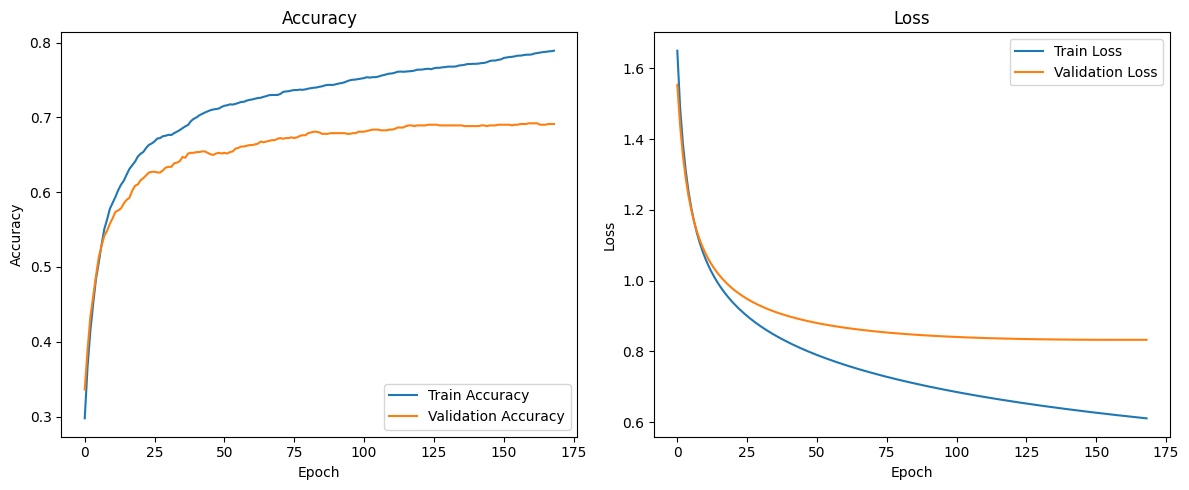

Found 3195 files belonging to 5 classes.
Found 1065 files belonging to 5 classes.

|------------------------------| Training Fully Connected Layers |--------------------------------|


|--------------------------| Training Complete |---------------------------|

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - accuracy: 0.4683 - loss: 1.3455 - precision_4: 0.5522 - recall_4: 0.3458 - val_accuracy: 0.6319 - val_loss: 0.9577 - val_precision_4: 0.7255 - val_recall_4: 0.5362 - learning_rate: 0.0050
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6462 - loss: 0.9103 - precision_4: 0.7335 - recall_4: 0.5690 - val_accuracy: 0.6413 - val_loss: 0.9611 - val_precision_4: 0.6998 - val_recall_4: 0.5624 - learning_rate: 0.0050
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6726 - loss: 0.8388 - precision_4: 0.7446 - recall_4: 0.6009 - val_accuracy: 0.6366 - val_loss: 0.9932 - val_precision_4: 0.6971 - val_recall_4: 0.5662 - learning_rate: 0.0050
Epo

KeyboardInterrupt: 

In [ ]:


# treain new densenet121 on adverial only
best_model_path = '/content/drive/My Drive/garbage dataset'
dataset_name = 'garbage'


# Learning rates
learn_rate_fc = 1e-4

# Callback to stop model training when model converges
model_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# ------------------------ Build and Train the Model ------------------------ #
# Build DenseNet121
base_model = DenseNet121(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Create classification layers
global_average_pooling = GlobalAveragePooling2D()
classifier = Dense(units=5, activation='softmax')

# Connect layers
inputs = Input(shape=(img_height, img_width, 3))
model = base_model(inputs)
model = global_average_pooling(model)
outputs = classifier(model)

# Build DenseNet121 model
dense_net_121 = Model(inputs, outputs, name='DenseNet121')

# Create training dataset
adversarial_train_data = image_dataset_from_directory(
    train_adver_dir,
    # validation_split = 0,
    # seed = 123,
    image_size = (img_height, img_width),
    # batch_size = batch_size,
    label_mode = 'categorical'
)

# Normalize training dataset pixel values
adversarial_train_data = adversarial_train_data.map(process)
adversarial_train_data = adversarial_train_data.cache().prefetch(buffer_size=AUTOTUNE)

# Create validation dataset
adversarial_val_data = image_dataset_from_directory(
    val_adver_dir,
    # validation_split = 0,
    # seed = 123,
    image_size = (img_height, img_width),
    # batch_size = batch_size,
    label_mode = 'categorical'
)

# Normalize validation dataset pixel values
adversarial_val_data = adversarial_val_data.map(process)
adversarial_val_data = adversarial_val_data.cache().prefetch(buffer_size=AUTOTUNE)


# Compile model
dense_net_121.compile(
    optimizer=Adam(learn_rate_fc),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Train the model
print('\n|------------------------------| Training Fully Connected Layers |--------------------------------|\n')
model_checkpoint_fc = ModelCheckpoint(
    best_model_path + '/adversarial-2-densenet121-' + dataset_name + '-{epoch:02d}-{val_accuracy:.4f}.keras',
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)


# # Example of using SGD with momentum

# Fit the model and save history
adversarial_1_densenet121 = dense_net_121.fit(
    adversarial_train_data,
    validation_data=adversarial_val_data,
    epochs=epochs,
    verbose=1,
    callbacks=[model_checkpoint_fc, model_callback]
)

print('\n|--------------------------| Training Complete |---------------------------|\n')








# Freeze some layers
# for layer in dense_net_121.layers[:-16]:  # Adjust based on your architecture
#     layer.trainable = False

# # Compile the model
# optimizer = Adam(learning_rate=5e-3)
# dense_net_121.compile(optimizer=optimizer, loss='categorical_crossentropy',
#                       metrics=['accuracy', Precision(), Recall()])

#
# Set up callbacks
# model_checkpoint_fc = ModelCheckpoint('fine_tuned_model.keras', monitor='val_loss', save_best_only=True)
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-4)

# Fit the model
# history = dense_net_121.fit(
#     combined_train_data,
#     validation_data=val_data,
#     epochs=200,  # Adjust as needed
#     verbose=1,
#     callbacks=[model_checkpoint_fc, lr_scheduler]
# )


# Call the plot function
plot_history(adversarial_1_densenet121)






In [ ]:
##train the trainded DenseNet121 on both images
# Load the pre-trained model
best_model_path = '/content/drive/My Drive/garbage dataset/densenet121-garbage-189-0.8216.keras'
dense_net_121 = load_model(best_model_path)

#dense_net_121.summary()
# Freeze some layers
for layer in dense_net_121.layers[:-16]:  # Adjust based on your architecture
    layer.trainable = False

# Compile the model
optimizer = Adam(learning_rate=5e-3)
dense_net_121.compile(optimizer=optimizer, loss='categorical_crossentropy',
                      metrics=['accuracy', Precision(), Recall()])



adversarial_train_data = image_dataset_from_directory(
    train_adver_dir,
    # validation_split = 0,
    # seed = 123,
    image_size = (img_height, img_width),
    # batch_size = batch_size,
    label_mode = 'categorical'
)

# Normalize training dataset pixel values
adversarial_train_data = adversarial_train_data.map(process)
#adversarial_train_data = adversarial_train_data.cache().prefetch(buffer_size=AUTOTUNE)

# Create validation dataset
adversarial_val_data = image_dataset_from_directory(
    val_adver_dir,
    # validation_split = 0,
    # seed = 123,
    image_size = (img_height, img_width),
    # batch_size = batch_size,
    label_mode = 'categorical'
)

# Normalize validation dataset pixel values
adversarial_val_data = adversarial_val_data.map(process)

#adversarial_val_data = adversarial_val_data.cache().prefetch(buffer_size=AUTOTUNE)

combined_train_data = train_data.concatenate(adversarial_train_data)
combined_train_data = combined_train_data.shuffle(buffer_size=1000)
combined__val_data = val_data.concatenate(adversarial_val_data)
combined__val_data = combined__val_data.shuffle(buffer_size=1000)

best_model_path = '/content/drive/My Drive/garbage dataset'
dataset_name = 'garbage'

model_checkpoint_fc = ModelCheckpoint(
    best_model_path + '/adversarial-2-densenet121-' + dataset_name + '-{epoch:02d}-{val_accuracy:.4f}.keras',
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)
# Set up callbacks
# model_checkpoint_fc = ModelCheckpoint('fine_tuned_model.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-4)

# Fit the model
adversarial_2_densenet121 = dense_net_121.fit(
    combined_train_data,
    validation_data=combined__val_data,
    epochs=44,  # Adjust as needed
    verbose=1,
    callbacks=[model_checkpoint_fc, lr_scheduler]
)


# Call the plot function
plot_history(adversarial_2_densenet121)

Model: "DenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,052,881 (26.90 MB)

 Trainable params: 5,125 (20.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 10,252 (40.05 KB)

Found 3195 files belonging to 5 classes.
Found 1065 files belonging to 5 classes.
Epoch 1/44
200/200 ━━━━━━━━━━━━━━━━━━━━ 50s 117ms/step - accuracy: 0.4734 - loss: 3.8055 - precision_7: 0.4914 - recall_7: 0.4521 - val_accuracy: 0.5164 - val_loss: 2.7103 - val_precision_7: 0.5275 - val_recall_7: 0.5042 - learning_rate: 0.0050
Epoch 2/44
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5706 - loss: 2.1336 - precision_7: 0.6025 - recall_7: 0.5429 - val_accuracy: 0.6516 - val_loss: 1.6703 - val_precision_7: 0.6583 - val_recall_7: 0.6385 - learning_rate: 0.0050
Epoch 3/44
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.6139 - loss: 1.7059 - precision_7: 0.6454 - recall_7: 0.5826 - val_accuracy: 0.6667 - val_loss: 1.5014 - val_precision_7: 0.6791 - val_recall_7: 0.6498 - learning_rate: 0.0050
Epoch 4/44
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.6203 - loss: 1.5450 - precision_7: 0.6580 - recall_7: 0.5888 - val_accuracy: 0.5343 - val_loss: 4.4185 - val_precisio

KeyboardInterrupt: 

In [ ]:

normal_data = image_dataset_from_directory(
    test_dir,
    # validation_split = 0,
    # seed = 123,
    image_size = (img_height, img_width),
    # batch_size = batch_size,
    label_mode = 'categorical'
)

# Normalize training dataset pixel values
normal_data = normal_data.map(process)
normal_data = normal_data.cache().prefetch(buffer_size=AUTOTUNE)

# Create validation dataset
adversarial_data = image_dataset_from_directory(
    test_adver_dir,
    # validation_split = 0,
    # seed = 123,
    image_size = (img_height, img_width),
    # batch_size = batch_size,
    label_mode = 'categorical'
)

# Normalize validation dataset pixel values
adversarial_data = adversarial_data.map(process)
adversarial_data = adversarial_data.cache().prefetch(buffer_size=AUTOTUNE)

normal_model = load_model('/content/drive/My Drive/garbage dataset/densenet121-garbage-189-0.8216.keras')
adversarial_model_1 = load_model('/content/drive/My Drive/garbage dataset/adversarial-densenet121-garbage-16-0.6930.keras')
adversarial_model_2 = load_model('/content/drive/My Drive/garbage dataset/adversarial-2-densenet121-garbage-159-0.6911.keras')
adversarial_model_3 = load_model('/content/drive/My Drive/garbage dataset/adversarial-3-densenet121-garbage-16-0.7061.keras')


print("Normal Model Results:")

normal_model_on_normal_data = normal_model.evaluate(normal_data)
print("Results with normal data", normal_model_on_normal_data)

normal_model_on_adversarial_data = normal_model.evaluate(adversarial_data)
print("Results with Adversarial Data:", normal_model_on_adversarial_data)

print("adversarial Model 1 Results:")

adversarial_1_model_on_normal_data = adversarial_model_1.evaluate(normal_data)
print("Results with normal data", adversarial_1_model_on_normal_data)

normal_model_on_adversarial_data = adversarial_model_1.evaluate(adversarial_data)
print("Results with Adversarial Data:", normal_model_on_adversarial_data)

print("adversarial Model 2 Results:")

adversarial_2_model_on_normal_data = adversarial_model_2.evaluate(normal_data)
print("Results with normal data", adversarial_2_model_on_normal_data)

normal_model_2_on_adversarial_data = adversarial_model_2.evaluate(adversarial_data)
print("Results with Adversarial Data:", normal_model_2_on_adversarial_data)

print("adversarial Model 3 Results:")

adversarial_3_model_on_normal_data = adversarial_model_3.evaluate(normal_data)
print("Results with normal data", adversarial_3_model_on_normal_data)

normal_model_3_on_adversarial_data = adversarial_model_3.evaluate(adversarial_data)
print("Results with Adversarial Data:", normal_model_3_on_adversarial_data)


Found 1066 files belonging to 5 classes.
Found 1066 files belonging to 5 classes.
Normal Model Results:
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 303ms/step - accuracy: 0.8138 - loss: 0.4843 - precision_8: 0.8423 - recall_8: 0.7878
Results with normal data [0.48826825618743896, 0.8067542314529419, 0.8326693177223206, 0.7842401266098022]
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5989 - loss: 1.2862 - precision_8: 0.6463 - recall_8: 0.5706
Results with Adversarial Data: [1.3564728498458862, 0.598499059677124, 0.6346356868743896, 0.5637898445129395]
adversarial Model 1 Results:
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.7340 - loss: 0.6846 - precision_4: 0.7720 - recall_4: 0.6639
Results with normal data [0.6982240676879883, 0.7251406908035278, 0.7711496949195862, 0.6669793725013733]
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6550 - loss: 0.9128 - precision_4: 0.7248 - recall_4: 0.6068
Results with Adversarial Data: [0.8926333785057068, 0.6632270216941833, 0.71794

In [ ]:
from rich.console import Console
from rich.table import Table

# Initialize the console
console = Console()

# Create a table
table = Table(title="Model Evaluation Results")

# Define the table columns
table.add_column("Model", justify="left", style="cyan", no_wrap=True)
table.add_column("Data Type", justify="left", style="magenta", no_wrap=True)
table.add_column("Accuracy", justify="right", style="green")
table.add_column("Loss", justify="right", style="red")

# Add Normal Model Results
table.add_row("Normal Model", "", "", "")
table.add_row("", "Normal Data", f"{normal_model_on_normal_data[1]:.2f}", f"{normal_model_on_normal_data[0]:.2f}")
table.add_row("", "Adversarial Data", f"{normal_model_on_adversarial_data[1]:.2f}", f"{normal_model_on_adversarial_data[0]:.2f}")
table.add_row("", "", "", "")  # Spacer

# Add Adversarial Model 1 Results
table.add_row("Adversarial Model 1", "", "", "")
table.add_row("", "Normal Data", f"{adversarial_1_model_on_normal_data[1]:.2f}", f"{adversarial_1_model_on_normal_data[0]:.2f}")
table.add_row("", "Adversarial Data", f"{adversarial_1_model_on_adversarial_data[1]:.2f}", f"{adversarial_1_model_on_adversarial_data[0]:.2f}")
table.add_row("", "", "", "")  # Spacer

# # Add Adversarial Model 2 Results
# table.add_row("Adversarial Model 2", "", "", "")
# table.add_row("", "Normal Data", f"{adversarial_2_model_on_normal_data[1]:.2f}", f"{adversarial_2_model_on_normal_data[0]:.2f}")
# table.add_row("", "Adversarial Data", f"{adversarial_2_model_on_adversarial_data[1]:.2f}", f"{adversarial_2_model_on_adversarial_data[0]:.2f}")
# table.add_row("", "", "", "")  # Spacer

# Add Adversarial Model 3 Results
table.add_row("Adversarial Model 2", "", "", "")
table.add_row("", "Normal Data", f"{adversarial_3_model_on_normal_data[1]:.2f}", f"{adversarial_3_model_on_normal_data[0]:.2f}")
table.add_row("", "Adversarial Data", f"{adversarial_3_model_on_adversarial_data[1]:.2f}", f"{adversarial_3_model_on_adversarial_data[0]:.2f}")

# Print the table
console.print(table)


                  Model Evaluation Results                  
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━┓
┃ Model               ┃ Data Type        ┃ Accuracy ┃ Loss ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━┩
│ Normal Model        │                  │          │      │
│                     │ Normal Data      │     0.81 │ 0.49 │
│                     │ Adversarial Data │     0.60 │ 1.36 │
│                     │                  │          │      │
│ Adversarial Model 1 │                  │          │      │
│                     │ Normal Data      │     0.73 │ 0.70 │
│                     │ Adversarial Data │     0.66 │ 0.89 │
│                     │                  │          │      │
│ Adversarial Model 2 │                  │          │      │
│                     │ Normal Data      │     0.72 │ 0.75 │
│                     │ Adversarial Data │     0.63 │ 1.03 │
└─────────────────────┴──────────────────┴──────────┴──────┘

In [ ]:


# # reain new densenet121 on adverial only
# best_model_path = '/content/drive/My Drive/garbage dataset'
# dataset_name = 'garbage'


# # Learning rates
# learn_rate_fc = 1e-4

# # Callback to stop model training when model converges
# model_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# # ------------------------ Build and Train the Model ------------------------ #
# # Build DenseNet121
# base_model = DenseNet121(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
# base_model.trainable = False

# # Create classification layers
# global_average_pooling = GlobalAveragePooling2D()
# classifier = Dense(units=5, activation='softmax')

# # Connect layers
# inputs = Input(shape=(img_height, img_width, 3))
# model = base_model(inputs)
# model = global_average_pooling(model)
# outputs = classifier(model)

# # Build DenseNet121 model
# dense_net_121 = Model(inputs, outputs, name='DenseNet121')


# # Create training dataset
# adversarial_train_data = image_dataset_from_directory(
#     train_adver_dir,
#     # validation_split = 0,
#     # seed = 123,
#     image_size = (img_height, img_width),
#     # batch_size = batch_size,
#     label_mode = 'categorical'
# )

# # Normalize training dataset pixel values
# adversarial_train_data = adversarial_train_data.map(process)
# adversarial_train_data = adversarial_train_data.cache().prefetch(buffer_size=AUTOTUNE)

# # Create validation dataset
# adversarial_val_data = image_dataset_from_directory(
#     val_adver_dir,
#     # validation_split = 0,
#     # seed = 123,
#     image_size = (img_height, img_width),
#     # batch_size = batch_size,
#     label_mode = 'categorical'
# )

# # Normalize validation dataset pixel values
# adversarial_val_data = adversarial_val_data.map(process)
# adversarial_val_data = adversarial_val_data.cache().prefetch(buffer_size=AUTOTUNE)


# # Compile model
# dense_net_121.compile(
#     optimizer=Adam(learn_rate_fc),
#     loss='categorical_crossentropy',
#     metrics=['accuracy', Precision(), Recall()]
# )

# # Train the model
# print('\n|------------------------------| Training Fully Connected Layers |--------------------------------|\n')
# model_checkpoint_fc = ModelCheckpoint(
#     best_model_path + '/adversarial-1-densenet121-' + dataset_name + '-{epoch:02d}-{val_accuracy:.4f}.keras',
#     save_best_only=True,
#     save_weights_only=False,
#     mode='auto'
# )


# # # Example of using SGD with momentum

# # Fit the model and save history
# adversarial_1_densenet121 = dense_net_121.fit(
#     adversarial_train_data,
#     validation_data=adversarial_val_data,
#     epochs=epochs,
#     verbose=1,
#     callbacks=[model_checkpoint_fc, model_callback]
# )

# print('\n|--------------------------| Training Complete |---------------------------|\n')



# # Call the plot function
# plot_history(adversarial_1_densenet121)

Found 3195 files belonging to 5 classes.
Found 1065 files belonging to 5 classes.

|------------------------------| Training Fully Connected Layers |--------------------------------|

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 112s 939ms/step - accuracy: 0.1976 - loss: 1.8668 - precision_1: 0.1955 - recall_1: 0.0478 - val_accuracy: 0.2498 - val_loss: 1.6980 - val_precision_1: 0.3131 - val_recall_1: 0.0629
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.3002 - loss: 1.6032 - precision_1: 0.3802 - recall_1: 0.0784 - val_accuracy: 0.3117 - val_loss: 1.5439 - val_precision_1: 0.4091 - val_recall_1: 0.0761
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.3528 - loss: 1.4672 - precision_1: 0.4602 - recall_1: 0.1038 - val_accuracy: 0.3812 - val_loss: 1.4346 - val_precision_1: 0.5135 - val_recall_1: 0.1070
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.4097 - loss: 1.3702 - precision_1: 0.5314 - recall_1: 0.1355 - val_accuracy: 0.4197 -

KeyboardInterrupt: 

In [ ]:

# Create the new parent directory if it doesn't exist
os.makedirs(dataset_dir, exist_ok=True)

# Loop through each folder in the parent directory
for folder_name in os.listdir(parent_dir):
    folder_path = os.path.join(parent_dir, folder_name)

    # Check if it is a directory
    if os.path.isdir(folder_path):
        # Create a corresponding folder in the new directory
        new_folder_path = os.path.join(dataset_dir, folder_name)
        os.makedirs(new_folder_path, exist_ok=True)

        # List all files in the folder
        for index, file_name in enumerate(os.listdir(folder_path)):
            # Only rename files that are images (you can adjust the extensions)
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                # Create new file name
                new_file_name = f"{folder_name}_{index+1}{os.path.splitext(file_name)[1]}"
                new_file_path = os.path.join(new_folder_path, new_file_name)

                # Check if the new file name already exists
                counter = 1
                while os.path.exists(new_file_path):
                    new_file_name = f"{folder_name}_{index+1}_{counter}{os.path.splitext(file_name)[1]}"
                    new_file_path = os.path.join(new_folder_path, new_file_name)
                    counter += 1

                # Copy the file to the new location with the new name
                old_file_path = os.path.join(folder_path, file_name)
                shutil.copy(old_file_path, new_file_path)
                #print(f"Copied and renamed '{old_file_path}' to '{new_file_path}'")

#print("Renaming and copying completed.")


KeyboardInterrupt: 

def create_model():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=True, weights=None, classes=9)  # 9 classes
    model = models.Sequential()
    model.add(base_model)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def generate_adversarial_example2(model, image, label, epsilon=0.1):
    """Generate adversarial examples using FGSM."""
    image_tensor = tf.convert_to_tensor(image)
    image_tensor = tf.Variable(image_tensor)

    with tf.GradientTape() as tape:
        prediction = model(image_tensor)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)

    gradients = tape.gradient(loss, image_tensor)
    signed_gradients = tf.sign(gradients)

    adversarial_image = image_tensor + epsilon * signed_gradients
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)

    return adversarial_image.numpy()

In [ ]:
def save_images_and_metadata(train_data, save_dir, model, epsilon=0.1):
    """Generate and save normal and adversarial images along with metadata."""
    data = []

    for batch_index, (images, lbls) in enumerate(train_data):
        for i in range(len(images)):
            normal_image = images[i]
            adversarial_image = generate_adversarial_example2(model, images[i:i+1], lbls[i:i+1], epsilon)
            label = np.argmax(lbls[i])  # Get the label index

            # Create unique filenames
            normal_image_filename = f'normal_{batch_index * train_data.batch_size + i}_label_{label}.png'
            adversarial_image_filename = f'adversarial_{batch_index * train_data.batch_size + i}_label_{label}.png'

            # Save the images
            save_img(os.path.join(save_dir, normal_image_filename), normal_image)
            save_img(os.path.join(save_dir, adversarial_image_filename), adversarial_image[0])

            # Store the filenames and labels
            data.append((normal_image_filename, adversarial_image_filename, lbls[i]))

    # Save the metadata as a .npy file
    data_array = np.array(data, dtype=object)
    np.save(os.path.join(save_dir, 'metadata.npy'), data_array)

In [ ]:

def display_images(image_number, save_dir, class_names, label):
    """Display normal and adversarial images along with their labels using an index."""
    # Create full paths for the images based on your naming convention
    normal_image_filename = f'normal_{image_number}_label_{label}.png'
    adversarial_image_filename = f'adversarial_{image_number}_label_{label}.png'

    normal_image_path = os.path.join(save_dir, normal_image_filename)
    adversarial_image_path = os.path.join(save_dir, adversarial_image_filename)

    # Print file paths for debugging
    #print(f"Normal image path: {normal_image_path}")
    #print(f"Adversarial image path: {adversarial_image_path}")

    try:
        # Load images and convert to arrays
        normal_image = img_to_array(load_img(normal_image_path)) / 255.0
        adversarial_image = img_to_array(load_img(adversarial_image_path)) / 255.0

        # Get the class name based on the provided label
        class_name = class_names[label]

        plt.figure(figsize=(18, 6))

        # Display normal image
        plt.subplot(1, 3, 1)
        plt.imshow(normal_image)
        plt.title(f'Normal Image\nClass: {class_name} (Label: {label})')
        plt.axis('off')

        # Display adversarial image
        plt.subplot(1, 3, 2)
        plt.imshow(adversarial_image)
        plt.title(f'Adversarial Image\nClass: {class_name} (Label: {label})')
        plt.axis('off')

        # Calculate and display the absolute difference image
        difference_image = np.abs(normal_image - adversarial_image)
        plt.subplot(1, 3, 3)
        plt.imshow(difference_image)
        plt.title('Difference Image')
        plt.axis('off')

        plt.show()

    except FileNotFoundError as e:
        print(f"Error: {e}. Please check if the image files exist in the specified directory.")

    except Exception as e:
        print(f"An unexpected error occurred: {e}")



In [ ]:

def display_images_with_overlay(image_number, save_dir, class_names, label):
    """Display normal and adversarial images with overlays showing differences."""
    # Construct the expected filenames
    normal_image_filename = f'normal_{image_number}_label_{label}.png'
    adversarial_image_filename = f'adversarial_{image_number}_label_{label}.png'

    # Create full paths for the images
    normal_image_path = os.path.join(save_dir, normal_image_filename)
    adversarial_image_path = os.path.join(save_dir, adversarial_image_filename)

    try:
        # Load images and convert to arrays
        normal_image = img_to_array(load_img(normal_image_path)) / 255.0
        adversarial_image = img_to_array(load_img(adversarial_image_path)) / 255.0

        # Get class name
        class_name = class_names[label]

        # Calculate difference image
        difference_image = np.abs(normal_image - adversarial_image)

        # Create an overlay image with the same shape
        overlay = np.zeros_like(normal_image)
        overlay[difference_image > 0] = [1, 0, 0]  # Red overlay for differences

        # Combine images using the overlay
        combined_normal = np.where(difference_image > 0, overlay * 0.3 + normal_image * 0.7, normal_image)
        combined_adversarial = np.where(difference_image > 0, overlay * 0.3 + adversarial_image * 0.7, adversarial_image)

        plt.figure(figsize=(18, 6))

        # Display normal image with overlay
        plt.subplot(1, 2, 1)
        plt.imshow(combined_normal)
        plt.title(f'Normal Image with Overlay\nClass: {class_name} (Label: {label})')
        plt.axis('off')

        # Display adversarial image with overlay
        plt.subplot(1, 2, 2)
        plt.imshow(combined_adversarial)
        plt.title(f'Adversarial Image with Overlay\nClass: {class_name} (Label: {label})')
        plt.axis('off')

        plt.show()

    except FileNotFoundError as e:
        print(f"Error: {e}. Please check if the image files exist in the specified directory.")

    except Exception as e:
        print(f"An unexpected error occurred: {e}")


In [ ]:
def list_classes(train_dir):
    """List all classes in the training directory."""
    return [name for name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, name))]


In [ ]:
save_images_and_metadata(train_data, adversarial_and_normal_dir, model, epsilon)


In [ ]:
index = 1144  # Change this index to view different images
class_names =  list_classes(train_dir)
label = 6

display_images(index, adversarial_and_normal_dir, class_names, label)
display_images_with_overlay(index, adversarial_and_normal_dir, class_names, label)  # For overlay


NameError: name 'display_images' is not defined